In [111]:
import numpy as np  # linear algebra
import pandas as pd  # data processing
import os

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from IPython.display import Image as image_display

from PIL import Image, ImageOps
import cv2

# Clustering and dimension reduction
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Metrics
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score
from sklearn.model_selection import train_test_split

# Import Tensorflow, Keras, VGG16
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Flatten
from keras import Model
from keras.applications import VGG16

# Import Python helper functions
from helpers import *

# Suppress deprecation warnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Computer Vision: Automatic image labeling 

The data used for the automatic image labeling is the Yelp database, which contains 200 100 photos, with potential labels of: <b>inside</b>, <b>outside</b>, <b>drink</b>, <b>food</b> or <b>menu</b>.  

In order to equally represent each label, we will use 100 images from each label in our sample (we used 200 in the Jupyter notebooks), so we will be working on 500 images total.  

The objective of this exercise is to remove the original labels and to choose the most accurate method of automatically labeling the images.  

Two methods have been tested to choose the best-performing method:  
1. KMeans clustering of ORB (Oriented FAST and Rotated BRIEF) descriptors
2. Transfer Learning using Convolutional Neural Networks (VGG16)

In [112]:
directory = "F:\Ingenieur_IA\P6\cv_nlp\yelp_photos"
df = pd.read_json(directory + "\photos.json", lines=True)

In [113]:
print(f"The dimensions of photos.json are {df.shape[0]} lines and {df.shape[1]} rows.")
df.head(5)

The dimensions of photos.json are 200100 lines and 4 rows.


photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [114]:
labels = df.label.unique().tolist()
labels

['inside', 'outside', 'drink', 'food', 'menu']

In [115]:
# let's save 100 images from each label into a sample dataframe

sample_df = pd.DataFrame()

for label in labels:
    label_df = df[df["label"] == label].sample(100, random_state=42)
    sample_df = sample_df.append(label_df, ignore_index=True)

## 1. KMeans clustering of ORB descriptors

Oriented FAST and Rotated BRIEF, or ORB for short, is an open source alternative to similar algorithms such as SIFT and SURF, which are patented. It uses FAST to detect the image keypoints and then computes the BRIEF descriptors. (More information here: https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html)  

### 1. A. Example of image preprocessing and computing descriptors

Before being able to detect descriptors in an image, we need to preprocess our images (or equalize their histograms, in our case). Let's take an image from our sample images and preprocess it: 

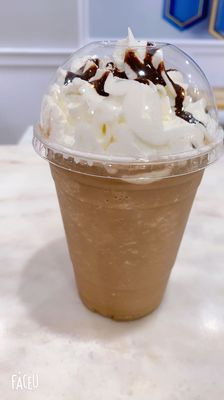

In [116]:
img = Image.open(directory + "\\photos\\" + sample_df.photo_id.iloc[260] + ".jpg")
img

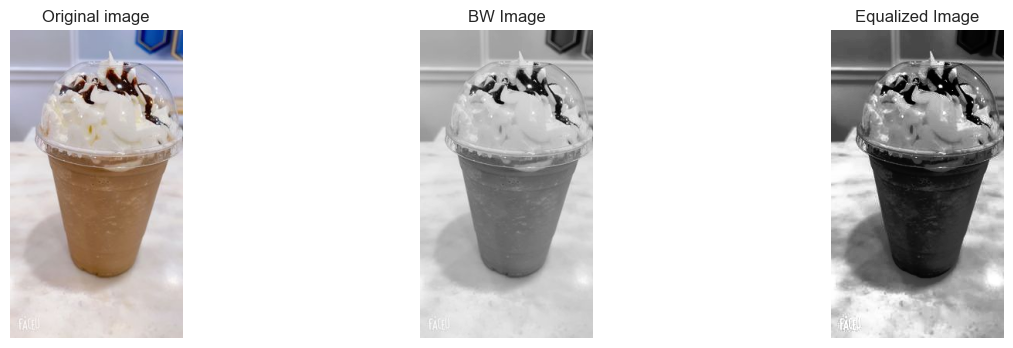

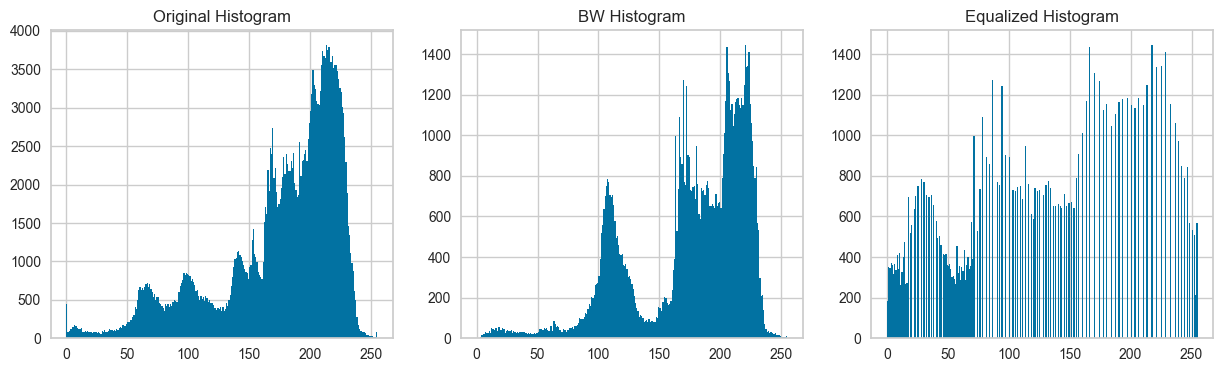

In [117]:
plt.figure(figsize=(15, 4))

image_color = img
image_bw = ImageOps.grayscale(image_color)
image_eq = ImageOps.equalize(image_bw)

images = [image_color, image_bw, image_eq]
titles = ["Original image", "BW Image", "Equalized Image"]

images_np = [np.array(i) for i in images]
titles_hists = ["Original Histogram", "BW Histogram", "Equalized Histogram"]

# plot images

for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i], "gray")
    plt.axis("off")
    plt.title(titles[i])
plt.show()

plt.figure(figsize=(15, 4))
# plot histograms

for i in range(len(images_np)):
    plt.subplot(1, len(images), i + 1)
    plt.hist(images_np[i].flatten(), bins=range(256))
    plt.title(titles_hists[i])
plt.show()

We see that the histogram has been equalized, let's now use ORB to compute 100 features and show them on the image:

In [118]:
orb = cv2.ORB_create(nfeatures=100)
keypoints = orb.detect(np.array(image_eq), None)
keypoints, descriptors = orb.compute(np.array(image_eq), keypoints)

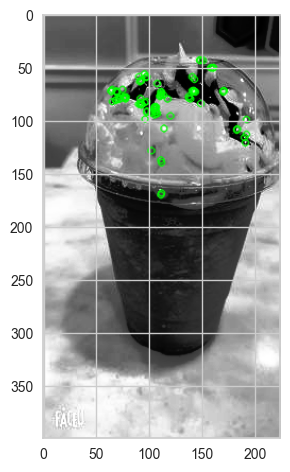

(<matplotlib.image.AxesImage at 0x2228c87a680>, None)

In [119]:
image2 = cv2.drawKeypoints(
    np.array(image_eq), keypoints, None, color=(0, 255, 0), flags=0
)
plt.imshow(image2), plt.show()

### 1. B. Clustering our images with the ORB descriptors

Each keypoint has an array of descriptors, which is the data we will ask KMeans to analyze and separate into 5 clusters (our 5 labels). 

In [120]:
def preprocess_images(sample_df):

    sample_images = []

    for i in range(0, sample_df.shape[0]):
        img = Image.open(directory + "\\photos\\" + sample_df.photo_id.iloc[i] + ".jpg")
        img = ImageOps.grayscale(img)
        img = ImageOps.equalize(img)
        img = np.array(img)
        sample_images.append(img)

    sample_df["images_np"] = sample_images

    return sample_df

In [121]:
sample_df

photo_id             business_id  \
0    cO58-hmFkBxDUQ4B0p40AA  v8IBu8Td9IuIvbcmHv9ZRA   
1    7_hiXIbS5Ub0_eiRxr5COg  7rMxt2f3uvC6xPQtHgQKLQ   
2    XseBUNM81RxxtfDgyjxXiA  Uw46n__imJ52D7Zh1vJVrQ   
3    _IRUZoGYSr9bICvBJrPnhw  3oFE-751lsSdkggDd7L-aw   
4    x8xVVzTI3yW5xZraRZNxfQ  NetawOi6wDa1mGJumW4-zQ   
..                      ...                     ...   
495  TrrpkyWzJA1sAY7po9wWNg  xKiTLjsWMHoeutot6lPZIw   
496  Kq8cwjZdFqRKsssjAfzWdQ  -iGzevsRYAi990-Lt-iMoQ   
497  Ao5u47KHjqq5mKQYuU4pIQ  sihT-_DtwOdnDDDJbXN22A   
498  uSbyFRqroJJsaSfOO_5Ucg  XQoSWEyIGHMIZKxLZOpXSg   
499  PQxHjgh5ad6H3FSANECDpQ  3MIvd8aVC5N13sY8mq8wtg   

                                               caption   label  
0    You can bring in a framed pic of your pup to p...  inside  
1                                                       inside  
2    The Cowgirl's bathroom looks like a barn with ...  inside  
3                                               We ID.  inside  
4                                                       inside  
..                                                 ...     ...  
495                                           Tap List    menu  
496                                                       menu  
497                                                       menu  
498                                                       menu  
499                                                       menu  

[500 rows x 4 columns]

In [122]:
def get_descriptors(sample_df):

    descriptors = []
    keypoints = []

    orb = cv2.ORB_create(nfeatures=500)

    for img in sample_df.images_np:
        kp = orb.detect(img, None)
        kp, des = orb.compute(img, kp)
        descriptors.append(des)
        keypoints.append(kp)

    desc = []
    for i in range(sample_df.shape[0]):
        desc.append(np.concatenate(descriptors[i]))

    sample_df["descriptors"] = desc

    min_len = np.unique(list(map(len, sample_df.descriptors))).min()

    desc = []
    for i in range(sample_df.shape[0]):
        desc.append(np.concatenate(descriptors[i])[:min_len])

    sample_df["descriptors"] = desc

    return sample_df

In [123]:
sample_df.pipe(preprocess_images).pipe(get_descriptors)

photo_id             business_id  \
0    cO58-hmFkBxDUQ4B0p40AA  v8IBu8Td9IuIvbcmHv9ZRA   
1    7_hiXIbS5Ub0_eiRxr5COg  7rMxt2f3uvC6xPQtHgQKLQ   
2    XseBUNM81RxxtfDgyjxXiA  Uw46n__imJ52D7Zh1vJVrQ   
3    _IRUZoGYSr9bICvBJrPnhw  3oFE-751lsSdkggDd7L-aw   
4    x8xVVzTI3yW5xZraRZNxfQ  NetawOi6wDa1mGJumW4-zQ   
..                      ...                     ...   
495  TrrpkyWzJA1sAY7po9wWNg  xKiTLjsWMHoeutot6lPZIw   
496  Kq8cwjZdFqRKsssjAfzWdQ  -iGzevsRYAi990-Lt-iMoQ   
497  Ao5u47KHjqq5mKQYuU4pIQ  sihT-_DtwOdnDDDJbXN22A   
498  uSbyFRqroJJsaSfOO_5Ucg  XQoSWEyIGHMIZKxLZOpXSg   
499  PQxHjgh5ad6H3FSANECDpQ  3MIvd8aVC5N13sY8mq8wtg   

                                               caption   label  \
0    You can bring in a framed pic of your pup to p...  inside   
1                                                       inside   
2    The Cowgirl's bathroom looks like a barn with ...  inside   
3                                               We ID.  inside   
4                                                       inside   
..                                                 ...     ...   
495                                           Tap List    menu   
496                                                       menu   
497                                                       menu   
498                                                       menu   
499                                                       menu   

                                             images_np  \
0    [[114, 114, 112, 111, 108, 106, 104, 103, 101,...   
1    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2    [[209, 253, 247, 100, 89, 209, 231, 248, 160, ...   
3    [[146, 151, 157, 161, 159, 151, 137, 125, 104,...   
4    [[164, 164, 158, 147, 140, 131, 114, 88, 86, 7...   
..                                                 ...   
495  [[85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, ...   
496  [[11, 11, 11, 11, 11, 11, 11, 11, 9, 9, 9, 11,...   
497  [[55, 53, 59, 55, 52, 65, 73, 59, 55, 67, 55, ...   
498  [[224, 224, 226, 226, 228, 228, 226, 226, 226,...   
499  [[83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, ...   

                                           descriptors  
0    [64, 192, 30, 184, 32, 200, 121, 141, 190, 89,...  
1    [135, 220, 117, 218, 123, 189, 30, 233, 31, 86...  
2    [9, 155, 18, 250, 244, 140, 121, 215, 185, 9, ...  
3    [122, 49, 36, 72, 201, 245, 148, 70, 139, 92, ...  
4    [40, 105, 184, 113, 121, 217, 113, 7, 231, 165...  
..                                                 ...  
495  [18, 202, 212, 247, 70, 42, 236, 166, 239, 146...  
496  [254, 236, 20, 58, 137, 185, 20, 238, 155, 55,...  
497  [141, 141, 237, 115, 198, 86, 253, 183, 118, 1...  
498  [80, 147, 211, 69, 114, 122, 32, 246, 117, 1, ...  
499  [73, 253, 51, 117, 209, 207, 118, 55, 249, 224...  

[500 rows x 6 columns]

In [124]:
print(
    "Dimension of descriptors: "
    + str(len(sample_df.descriptors))
    + " descriptors of length "
    + str(len(sample_df.descriptors[0]))
)
print("First descriptor: " + str(sample_df.descriptors[0]))

Dimension of descriptors: 500 descriptors of length 10560
First descriptor: [ 64 192  30 ... 172 214 241]


We will then use PCA to reduce the dimension of our descriptors to explain 90% of the variance.

In [125]:
descriptors = get_batch_descriptors(
    photo_ids=sample_df["photo_id"], directory=directory
)

pca = PCA(n_components=0.90, random_state=42)
desc_pca = pca.fit_transform(descriptors)
print("Dimension after PCA reduction : ", desc_pca.shape)

Dimension after PCA reduction :  (500, 352)


And finally we will use KMeans to cluster our descriptors into 5 clusters (representing food, drink, outside, inside, menu).

In [126]:
kmeans = KMeans(n_clusters=5)
label = kmeans.fit_predict(desc_pca)
label

array([4, 0, 2, 1, 1, 4, 0, 3, 4, 0, 0, 1, 0, 2, 2, 3, 0, 1, 3, 4, 4, 4,
       1, 4, 4, 4, 1, 2, 4, 4, 4, 4, 2, 1, 1, 1, 1, 2, 1, 1, 0, 3, 4, 3,
       1, 4, 4, 4, 4, 3, 4, 1, 4, 1, 4, 3, 1, 2, 4, 3, 2, 1, 1, 0, 4, 4,
       0, 4, 4, 4, 4, 1, 0, 4, 3, 4, 4, 4, 1, 1, 4, 4, 4, 3, 0, 4, 3, 4,
       3, 1, 0, 1, 1, 1, 4, 2, 4, 1, 4, 1, 1, 3, 0, 3, 2, 1, 4, 4, 0, 1,
       4, 3, 1, 4, 1, 1, 2, 4, 3, 4, 3, 1, 3, 1, 0, 4, 2, 4, 4, 1, 4, 1,
       0, 3, 4, 4, 3, 4, 3, 4, 0, 3, 4, 1, 4, 1, 3, 1, 3, 1, 1, 3, 4, 3,
       4, 0, 1, 3, 3, 0, 1, 0, 1, 0, 0, 1, 2, 2, 3, 4, 0, 2, 0, 4, 1, 4,
       1, 2, 3, 3, 1, 4, 1, 4, 4, 4, 3, 3, 2, 1, 1, 4, 4, 0, 4, 0, 4, 3,
       2, 3, 3, 4, 3, 4, 3, 1, 4, 0, 0, 2, 0, 3, 0, 1, 0, 2, 0, 0, 1, 3,
       3, 3, 4, 1, 1, 4, 4, 2, 4, 2, 0, 1, 3, 2, 4, 3, 1, 3, 4, 3, 3, 4,
       4, 3, 3, 3, 3, 4, 4, 4, 4, 1, 4, 4, 0, 1, 4, 0, 1, 1, 1, 2, 4, 4,
       0, 1, 3, 1, 3, 4, 0, 0, 4, 1, 2, 1, 4, 0, 1, 3, 3, 4, 4, 1, 3, 4,
       3, 1, 3, 2, 2, 3, 3, 4, 3, 1, 2, 1, 3, 4, 0,

In [127]:
sample_df["kmeans_label"] = label
sample_df.groupby(by=sample_df.label).kmeans_label.value_counts()

label    kmeans_label
drink    4               28
         3               27
         1               21
         0               14
         2               10
food     4               29
         2               22
         3               21
         0               14
         1               14
inside   4               40
         1               27
         0               12
         3               12
         2                9
menu     2               27
         3               23
         0               19
         1               16
         4               15
outside  4               29
         1               25
         3               23
         0               14
         2                9
Name: kmeans_label, dtype: int64

We can notice with the comparison between the true label and the kmeans label that there is no noticeable pattern, we cannot say that the kmeans label 1 is most often given to photos with a true label of "food" for example.  

Let's visualize the data with t-SNE in two dimensions as a last attempt to find associations between the true and predicted labels.

ARI :  0.008404663146899817


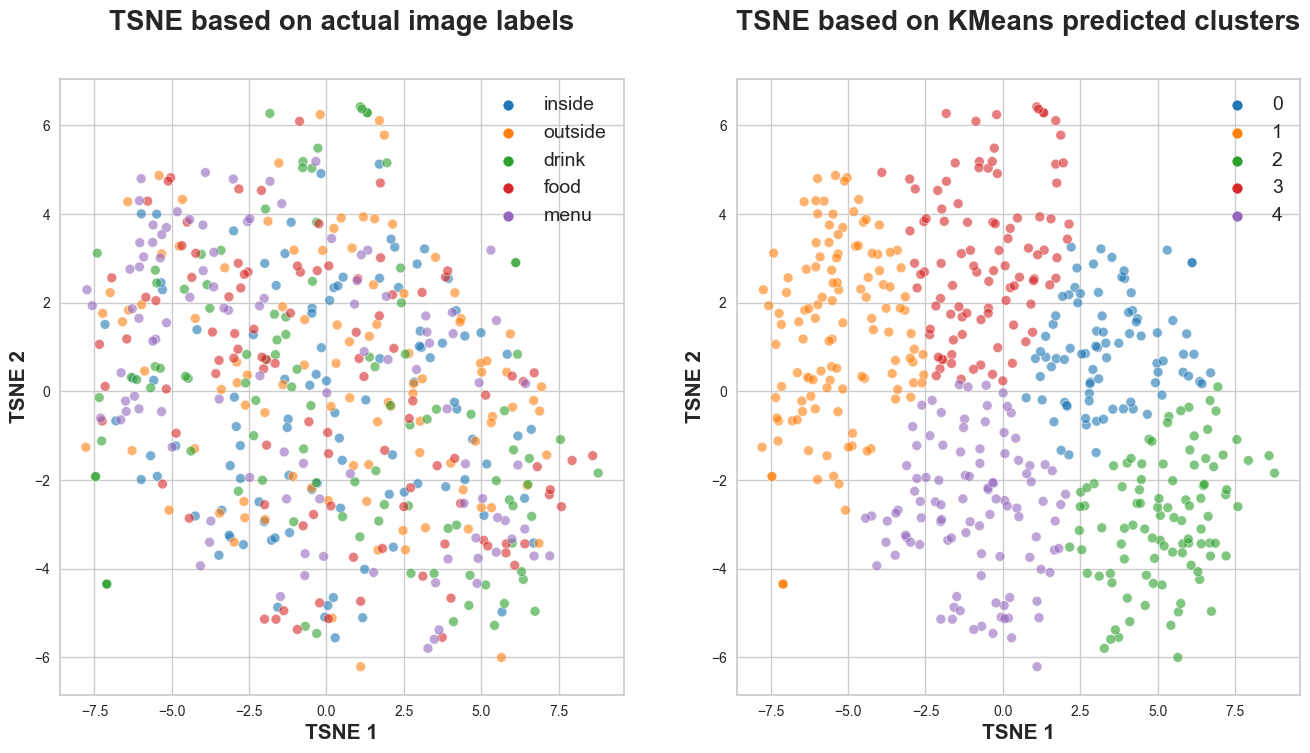

In [128]:
tsne_visualizer(
    descriptors=descriptors, photos_data=sample_df
)  # function carries out PCA itself

### 1. C. Conclusion

The adjusted rand index (ARI) of the true labels vs. the predicted labels is under 1%. This is a low number and it means our clustering with ORB predictors did not work as well as we hoped. In the next part, we will try to do something similar using a deep learning algorithm and hopefully get better results.

## 2. Transfer Learning with VGG16

A Convolutional Neural Network (CNN or ConvNet) is a type of neural network typically used in image recognition, image classification, object detections, face recognitions, etc. We will be using a neural network which has convolutional layers for feature extraction and pooling layers for reducing the dimensions of our feature maps.  

We will not be using the fully connected layers or softmax because we will not be training the model at this point but using the model pretrained on the labeled ImageNet database, so we will be carrying out Transfer Learning, or reusing a previously trained model on a new problem. 

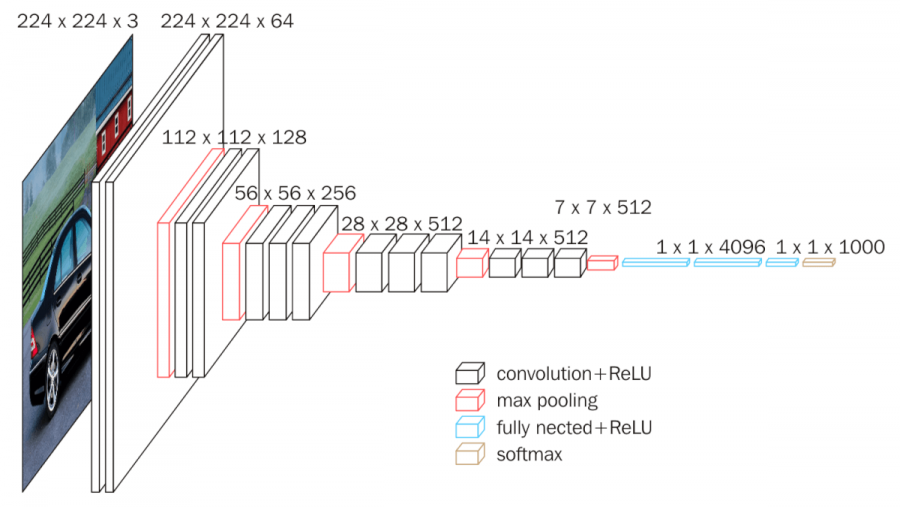

In [106]:
image_display(filename="vgg16.png")

Here is our model, where as expected we do not have the last fully connected and softmax layers:

In [107]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False  # do not train existing weights

x = Flatten()(vgg.output)  # flatten the last layer

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 2. A. Example of feature extraction with VGG16

The shape of our extracted features from the sample image is (7,7,512), corresponding to the last layer of our model or the last "max pooling" layer in VGG16 diagram above.

In [129]:
extract_vgg16_features(directory + "\\photos\\" + sample_df.photo_id.iloc[260] + ".jpg")

1/1 [==============================] - 3s 3s/step
(1, 7, 7, 512)


### 2. B. Feature extraction on 500 photos with VGG16

In [130]:
def get_vgg16_features():

    vgg16_feats = []

    for i in range(0, sample_df.shape[0]):
        img_path = str(directory + "\\photos\\" + sample_df.photo_id.iloc[i] + ".jpg")
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224, 3))

        x = tf.keras.utils.img_to_array(img)
        xs = np.expand_dims(x, axis=0)
        xs = vgg16.preprocess_input(xs)
        features = vgg.predict(xs)

        vgg16_feats.append(features.flatten())
        vgg16_feats = np.array(vgg16_feats)

    return vgg16_feats

In [131]:
vgg16_features = get_vgg16_features()

In [137]:
pca_vgg = PCA(n_components=0.80, random_state=42)
feat_pca_vgg = pca_vgg.fit_transform(vgg16_features)
print("Dimensions after PCA reduction: ", feat_pca_vgg.shape)

Dimensions after PCA reduction:  (500, 271)


ARI :  0.5967296347113074


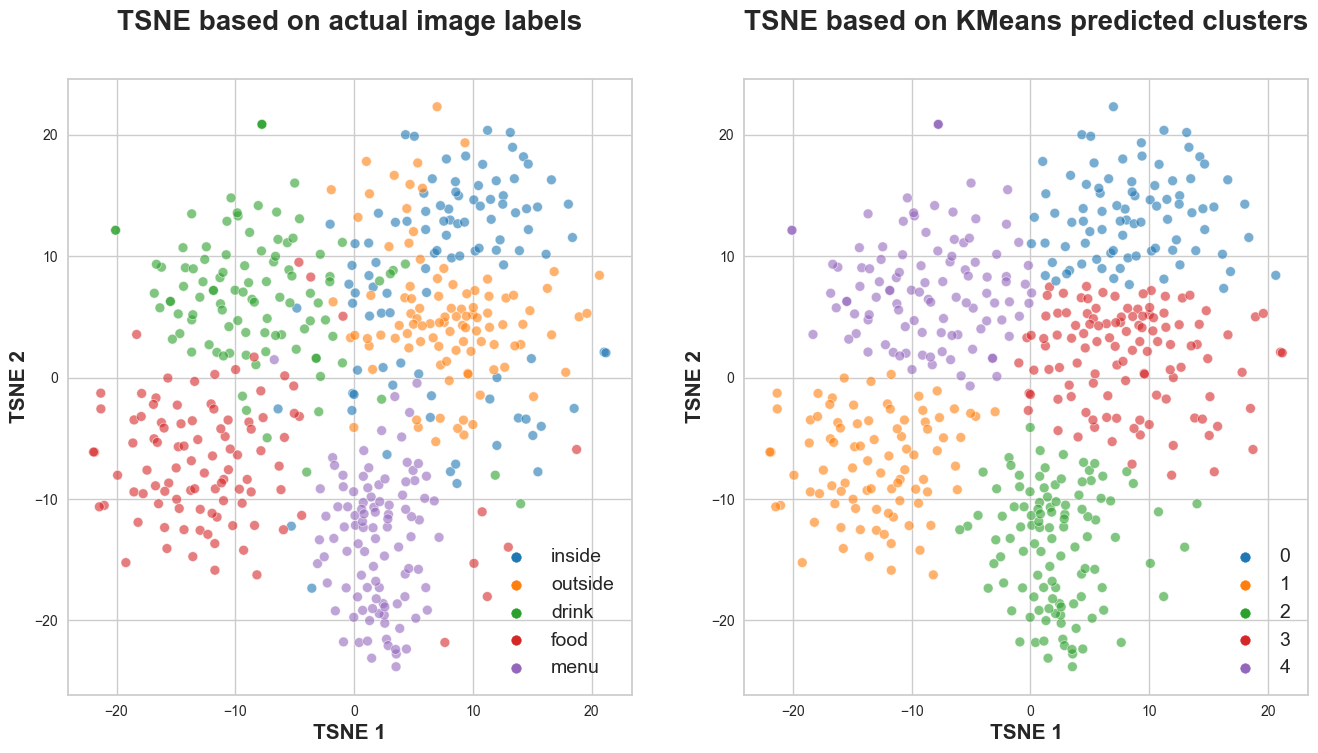

In [139]:
df_tsne = prep_tsne(features=feat_pca_vgg, true_labels=sample_df.label)
tsne_visualizer_vgg(df_tsne)

### 2. C. Results

We achieve an ARI score of 59,6% which is pretty good considering the model isn't trained on our data and we have only given it 500 photos to work with. Thanks to the t-SNE plots, we can see which true labels correspond to the KMeans predicted labels. We are going to map them to their names in order to have a clear classification of our results.

In [142]:
df_tsne

tsne1      tsne2   class  cluster
0     4.333772  20.010475  inside        0
1     2.303445   5.312585  inside        3
2     2.444421   0.832191  inside        3
3    11.982392  10.493880  inside        0
4    10.196750  10.428456  inside        0
..         ...        ...     ...      ...
495   1.868704 -18.211912    menu        2
496   6.043013 -17.296747    menu        2
497   2.557725 -14.693375    menu        2
498   2.955370 -10.501600    menu        2
499   4.476694  -6.979807    menu        2

[500 rows x 4 columns]

In [140]:
class_dictionary = {0: "inside", 1: "food", 2: "menu", 3: "outside", 4: "drink"}

In [143]:
df_tsne["predicted_class"] = df_tsne["cluster"].map(class_dictionary)

Classification Report
              precision    recall  f1-score   support

       drink       0.84      0.87      0.85       100
        food       0.94      0.84      0.89       100
      inside       0.70      0.59      0.64       100
        menu       0.86      0.94      0.90       100
     outside       0.67      0.76      0.71       100

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500

******************************************************
Confusion Matrix


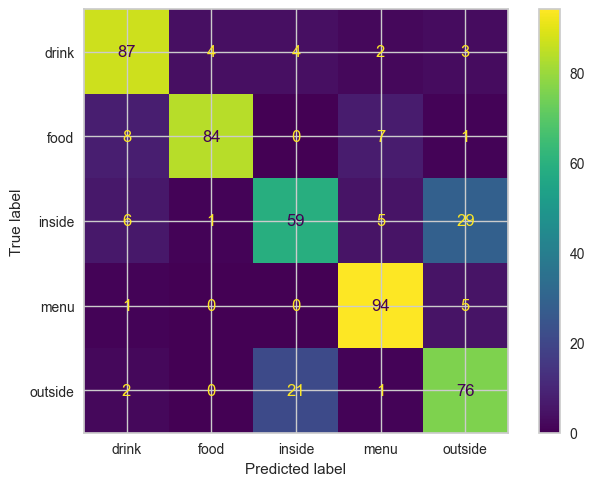

In [144]:
print("Classification Report")
print(classification_report(df_tsne["class"], df_tsne["predicted_class"]))
print("******************************************************")
print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(
    df_tsne["class"], df_tsne["predicted_class"]
)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=["drink", "food", "inside", "menu", "outside"],
)
cm_display.plot()
plt.show()

We have a total precision of 80%. The label predicted with most precision is "food" whilst the least precision was "outside". The labels most often confused are "inside" and "outside, as well as "food" and "drink".

### 2. D. Examples of mislabeled photos

<b>"Inside" predicted as "Outside": 29 occurences</b>

The reason for these mismatchings are probably the lighting in some of the photos, maybe a colder, daylight-resembling light causes the misinterpretation. The second photo has a framed picture of a sunset which could be detected by the model as being outside. 

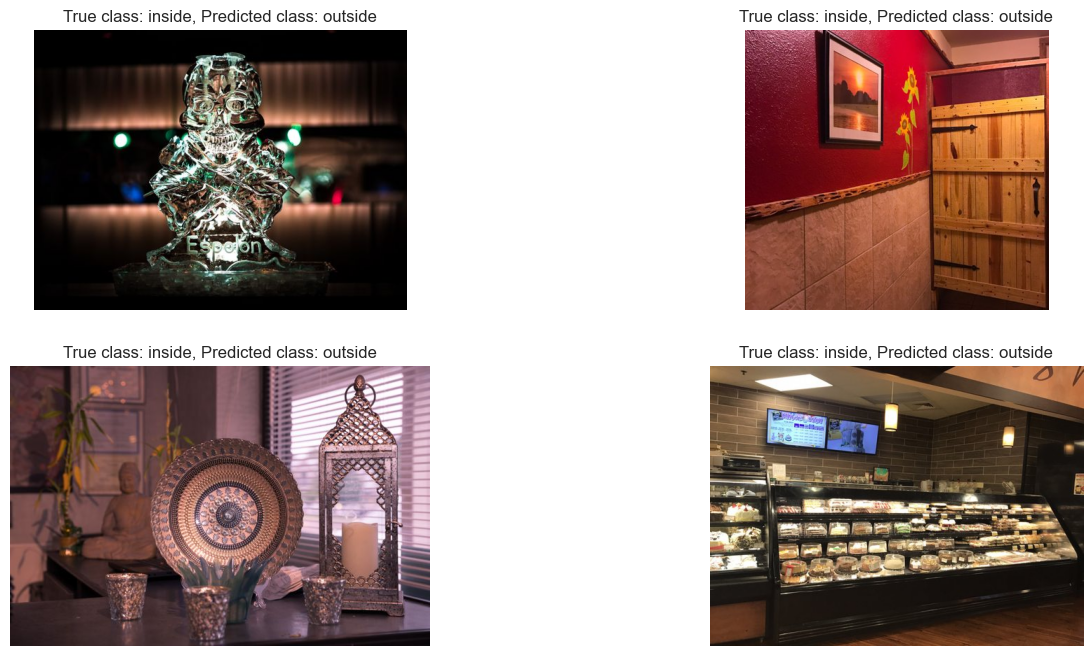

In [148]:
display_mislabeled_pics(
    true_class="inside",
    predicted_class="outside",
    df_tsne=df_tsne,
    photo_ids=sample_df.photo_id,
)

<b>"Outside" predicted as "Inside": 21 occurences</b>

The first photo is probably mislabeled from the beginning, as it is truly a photo of an interior. The second photo is under some sort of roof which might be misinterpreted as a ceiling. The fourth photo also has most of the top area covered with an umbrella and a roof which might be misinterpreted as a ceiling.

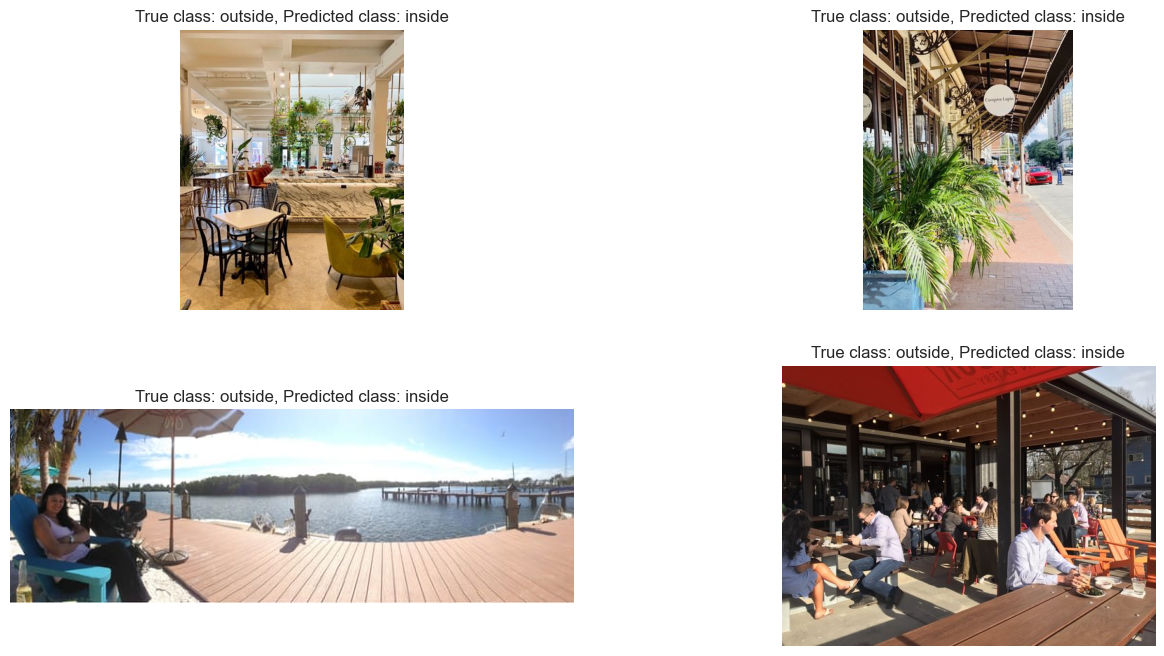

In [150]:
display_mislabeled_pics(
    true_class="outside",
    predicted_class="inside",
    df_tsne=df_tsne,
    photo_ids=sample_df.photo_id,
)

<b>"Food" predicted as "Drink": 8 occurences</b>

The first and third photo both have a round shaped bowl of sauce which might be misinterpreted as a drink. The third also has ice cubes found more commonly in drinks than food. The second has a similar plastic transparent cup and might be misinterpreted for resembling a small cup. The last photo is food presented in a cup so the cup itself might cause the issue. 

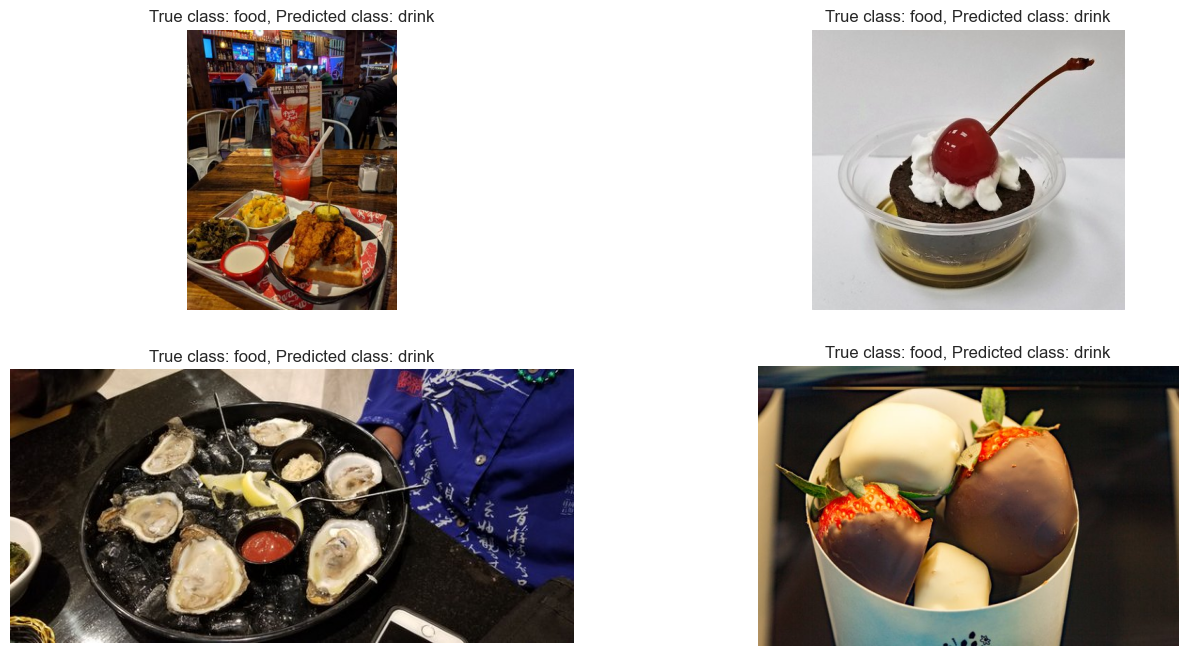

In [151]:
display_mislabeled_pics(
    true_class="food",
    predicted_class="drink",
    df_tsne=df_tsne,
    photo_ids=sample_df.photo_id,
)

<b>"Inside" predicted as "Drink": 6 occurences</b>

The first photo has drinks on the table which the model might be picking up on. There are also probably some objects on the other three photos which have elements of a drink that the model is misinterpreting, but that's difficult to analyze for us.

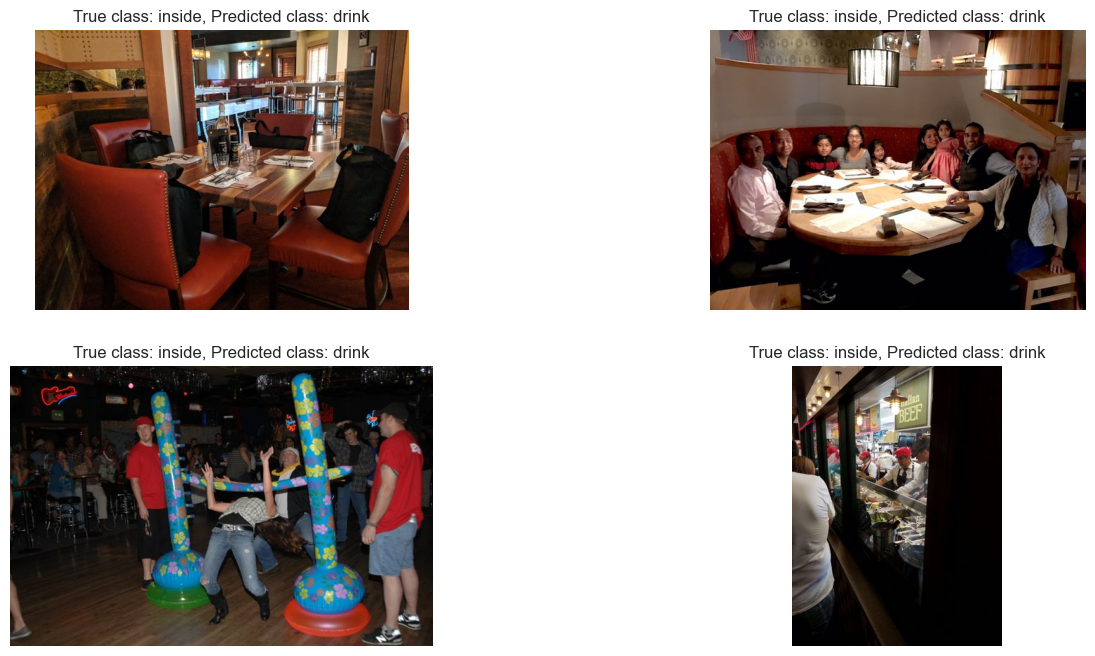

In [155]:
display_mislabeled_pics(
    true_class="inside",
    predicted_class="drink",
    df_tsne=df_tsne,
    photo_ids=sample_df.photo_id,
)

## 3. Conclusion

In synthesis, using the features extracted with the transfer learning model via VGG16 performed much better than using the features extracted through ORB. If we were to carry out a supervised learning on the VGG16 model and test it using not just 500 photos but thousands, we would certainly reach very satisfactory precision. 